In [3]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from dataset import ChessDataset, INDEX_TO_PIECE, filename_to_fen

Matplotlib is building the font cache; this may take a moment.


In [4]:
# Load a small subset without normalization so we can display raw images
raw_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = ChessDataset("kaggle/train", max_samples=1000, transform=raw_transform)
print(f"Dataset size: {len(dataset)}")

Dataset size: 1000


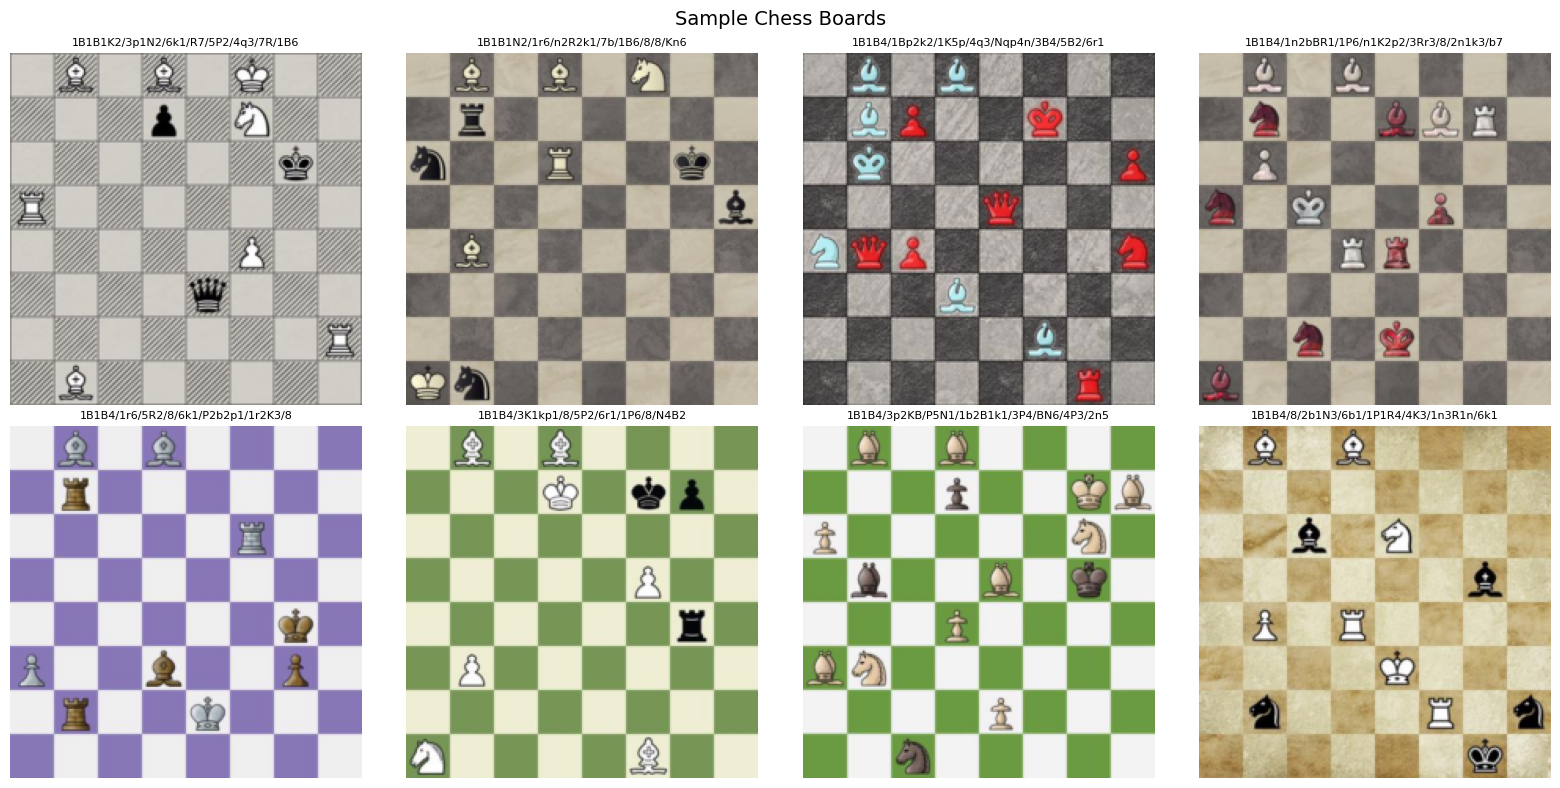

In [5]:
# Show a grid of sample boards with their FEN strings
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    image, labels = dataset[i]
    fen = filename_to_fen(dataset.filenames[i])
    ax.imshow(image.permute(1, 2, 0))  # CHW -> HWC
    ax.set_title(fen, fontsize=8)
    ax.axis("off")
plt.suptitle("Sample Chess Boards", fontsize=14)
plt.tight_layout()
plt.show()

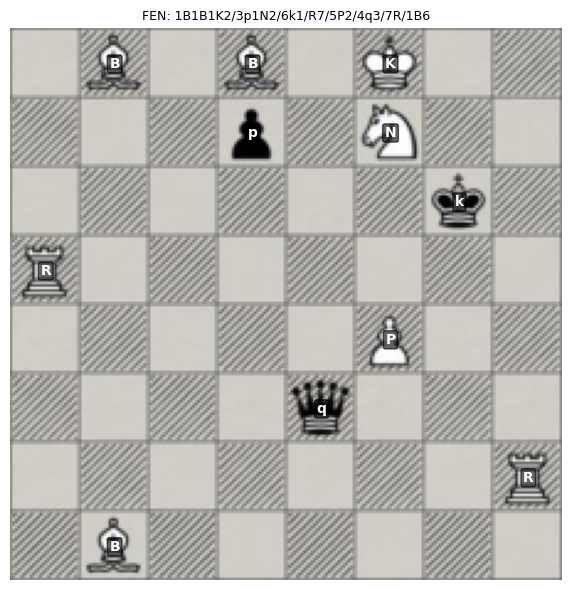

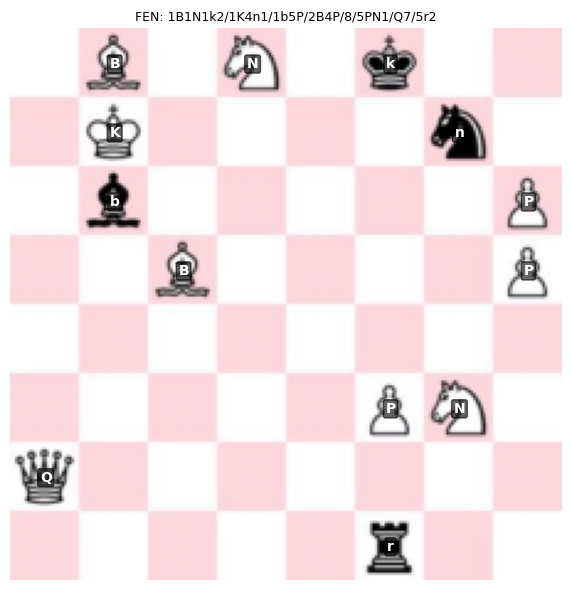

In [6]:
# Visualize one board with piece labels overlaid on each square
def show_board_with_labels(dataset, idx):
    image, labels = dataset[idx]
    fen = filename_to_fen(dataset.filenames[idx])

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image.permute(1, 2, 0))

    sq_size = 224 / 8
    for sq in range(64):
        row, col = divmod(sq, 8)
        piece = INDEX_TO_PIECE[labels[sq].item()]
        if piece != '.':
            ax.text(
                col * sq_size + sq_size / 2,
                row * sq_size + sq_size / 2,
                piece,
                ha="center", va="center",
                fontsize=10, fontweight="bold",
                color="white",
                bbox=dict(boxstyle="round,pad=0.15", fc="black", alpha=0.6),
            )

    ax.set_title(f"FEN: {fen}", fontsize=9)
    ax.axis("off")
    plt.tight_layout()
    plt.show()

show_board_with_labels(dataset, 0)
show_board_with_labels(dataset, 42)

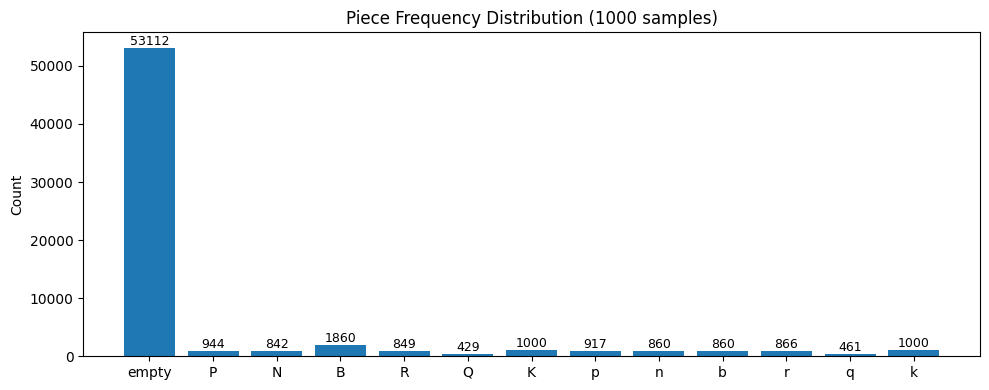

In [7]:
# Piece frequency distribution across the dataset
all_labels = torch.stack([dataset[i][1] for i in range(len(dataset))])  # (N, 64)
counts = torch.bincount(all_labels.flatten(), minlength=13)

piece_names = [INDEX_TO_PIECE[i] for i in range(13)]
piece_names[0] = "empty"

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.bar(piece_names, counts.numpy())
ax.set_ylabel("Count")
ax.set_title("Piece Frequency Distribution (1000 samples)")
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            str(count.item()), ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

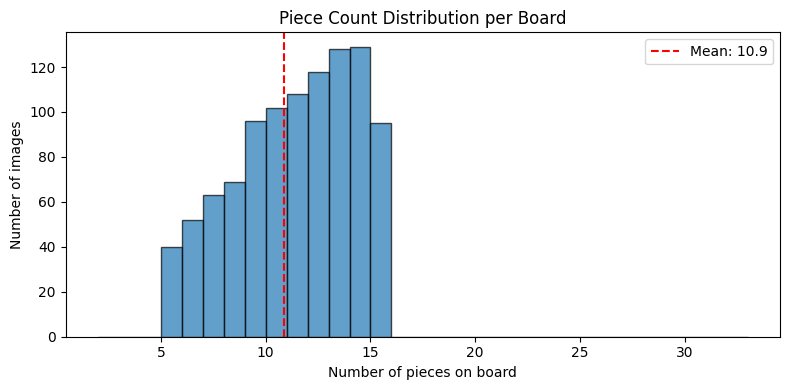

In [8]:
# Piece count per board — how many non-empty squares per image
pieces_per_board = (all_labels != 0).sum(dim=1).numpy()

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(pieces_per_board, bins=range(2, 34), edgecolor="black", alpha=0.7)
ax.set_xlabel("Number of pieces on board")
ax.set_ylabel("Number of images")
ax.set_title("Piece Count Distribution per Board")
ax.axvline(pieces_per_board.mean(), color="red", linestyle="--",
           label=f"Mean: {pieces_per_board.mean():.1f}")
ax.legend()
plt.tight_layout()
plt.show()